# Notebook to simply investigate data

In [5]:
import numpy as np
import matplotlib.pyplot as plt

data_3 = np.load('../datasets/P03/data.npy')
data_4 = np.load('../datasets/P04/data.npy')
data_5 = np.load('../datasets/P05/data.npy')
data_6 = np.load('../datasets/P06/data.npy')
data_7 = np.load('../datasets/P07/data.npy')
data_8 = np.load('../datasets/P08/data.npy')

data = np.stack([data_3, data_4, data_5, data_6, data_7, data_8], axis=0)

In [16]:
def low_rank_nd(data, rank):
    """
    Computes a low-rank approximation of an N-dimensional tensor using truncated SVD
    over the last two dimensions.

    Args:
        data (np.ndarray): Input tensor of shape (..., m, n), with ndim >= 2.
        rank (int): Number of singular values to keep.

    Returns:
        np.ndarray: Tensor of same shape as input, with rank-reduced approximation
                    over the last two axes.
    """
    # Ensure at least 2 dimensions
    if data.ndim < 2:
        raise ValueError("Input tensor must have at least 2 dimensions.")

    # Get shape
    *leading_dims, m, n = data.shape
    leading_size = np.prod(leading_dims)

    # Reshape to 2D: (prod of leading dims, m*n)
    reshaped_matrix = data.reshape((leading_size*n, m), order='F')

    # SVD
    U, s, Vh = np.linalg.svd(reshaped_matrix, full_matrices=False)
    k = min(rank, len(s))
    S = np.diag(s[:k])

    # Truncate and reconstruct
    reconstructed = U[:, :k] @ S @ Vh[:k, :]

    # Reshape back to original
    reconstructed = reconstructed.reshape((*leading_dims, m, n), order='F')
    return reconstructed

In [21]:
P03_LR = low_rank_nd(data_4, 8)

data_LR = low_rank_nd(data, 8)

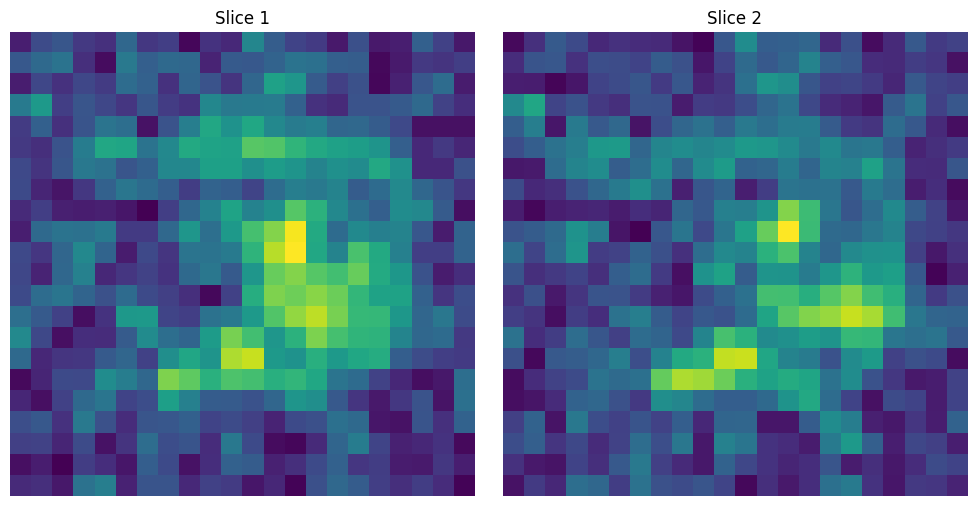

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Deine Slices (wie gehabt)
z, t, T = 10, 15, 7
Slice_1 = np.abs(P03_LR)[..., z, t, T]
Slice_2 = np.abs(data_LR[1, ...])[..., z, t, T]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(Slice_1, cmap='viridis')
axes[0].set_title('Slice 1')
axes[0].axis('off')

axes[1].imshow(Slice_2, cmap='viridis')
axes[1].set_title('Slice 2')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def build_basis(noisy: np.ndarray, rank: int):
    # noisy: (x, y, z, t, T)
    # bring t ans Ende, damit reshape((…, t)) t-dimension isoliert
    noisy2 = noisy.transpose(0, 1, 2, 4, 3)  # jetzt (x, y, z, T, t)
    x, y, z, T, t = noisy2.shape

    # flatten spatial+T zu Zeilen, Spektrum als Spalten
    M = noisy2.reshape((x * y * z * T, t), order='F')

    # SVD auf jeder Zeile = Spektrum
    U, S, Vh = np.linalg.svd(M, full_matrices=False)

    # Vh[:rank] sind die Top-r rechten Singularvektoren (in R^t)
    V_r = Vh[:rank].conj().T   # (t, rank)

    return V_r, S[:rank]

def project(data: np.ndarray, V_r: np.ndarray):
    # data: (x, y, z, t, T), V_r: (t, rank)
    data2 = data.transpose(0, 1, 2, 4, 3)     # (x,y,z,T,t)
    x, y, z, T, t = data2.shape

    M = data2.reshape((x*y*z*T, t), order='F')   # (N, t)
    C = M @ V_r                                 # (N, rank)
    R = C @ V_r.conj().T                        # (N, t)
    recon = R.reshape((x, y, z, T, t), order='F')\
               .transpose(0,1,2,4,3)            # zurück zu (x,y,z,t,T)

    return recon, C

In [64]:
V_3, _ = build_basis(data_3, 1)

V_4, _ = build_basis(data_4, 1)

data_3_3, _ = project(data_3, V_3)

data_3_4, _ = project(data_3, V_4)

data_3_3_ft = np.fft.fftshift(np.fft.fft(data_3_3, axis=-2), axes=-2)

data_3_4_ft = np.fft.fftshift(np.fft.fft(data_3_4, axis=-2), axes=-2)

data_3_ft = np.fft.fftshift(np.fft.fft(data_3, axis=-2), axes=-2)

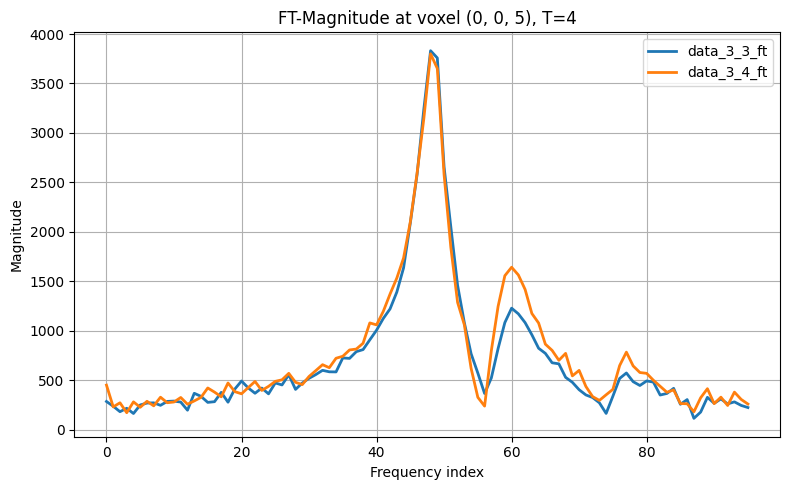

In [68]:
import matplotlib.pyplot as plt
import numpy as np

x, y, z, T = 0, 0, 5, 4

Slice_1 = np.abs(data_3_3_ft)[x, y, z, :, T]
Slice_2 = np.abs(data_3_4_ft)[x, y, z, :, T]

plt.figure(figsize=(8, 5))
plt.plot(Slice_1, label='data_3_3_ft', linewidth=2)
plt.plot(Slice_2, label='data_3_4_ft', linewidth=2)

plt.title(f'FT-Magnitude at voxel ({x}, {y}, {z}), T={T}')
plt.xlabel('Frequency index')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


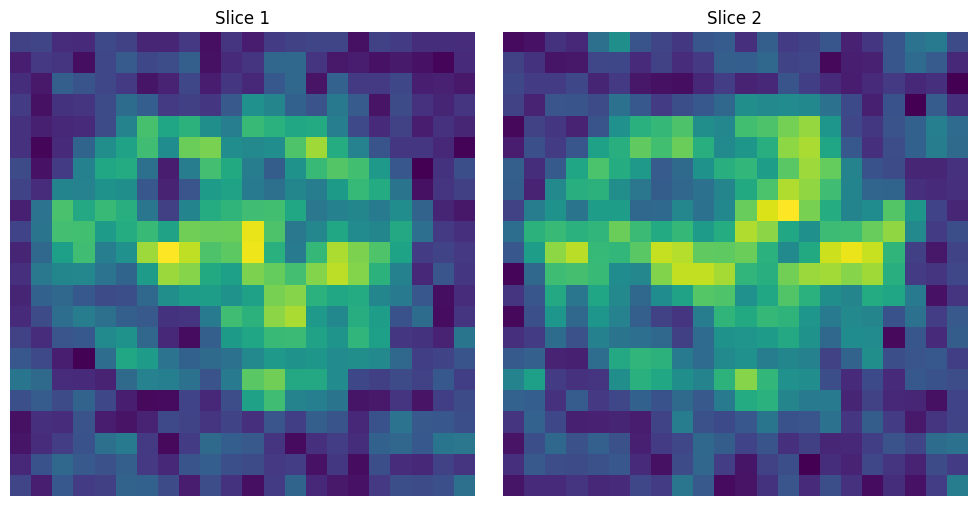

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Deine Slices (wie gehabt)
z, t, T = 10, 20, 7
Slice_1 = np.abs(data_3_3)[..., z, t, T]
Slice_2 = np.abs(data_3_4)[..., z, t, T]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(Slice_1, cmap='viridis')
axes[0].set_title('Slice 1')
axes[0].axis('off')

axes[1].imshow(Slice_2, cmap='viridis')
axes[1].set_title('Slice 2')
axes[1].axis('off')

plt.tight_layout()
plt.show()